# Illustration of simple convolution to build growth profiles
**David S. Fulford**  
*October, 2018*

In this example, we'll use the [numpy.convolve](https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html "Numpy reference for convolution") function to simplify the construction of a rigline profile. [Convolution](https://en.wikipedia.org/wiki/Convolution "Wikipedia") is a mathmetical operation that expresses how the shape of one function is modified by the other. We're interested in how the shape of our Production Profile is modified by a profile of well start dates or periods, so convolution makes a lot of sense to use in this case.

You can learn more background on convolution from [Khan Academy](https://www.khanacademy.org/math/differential-equations/laplace-transform/convolution-integral/v/introduction-to-the-convolution "Introduction to Convolution"), or from [Paul's Online Math Notes](http://tutorial.math.lamar.edu/Classes/DE/ConvolutionIntegrals.aspx "Convolution Integrals").

## <center> Convolution Illustration </center>
![Convolution Illustration](https://upload.wikimedia.org/wikipedia/commons/b/b9/Convolution_of_spiky_function_with_box2.gif)

#### Import the libraries we'll be using.

* [Numpy](http://www.numpy.org/) is one of the fundamental packages for Python that provides access to powerful functions for working with arrays.
* [Matplotlib](https://matplotlib.org/) is a simple and powerful library for plotting.
* [Sympy](https://www.sympy.org) is a symbolic math library.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy as sym

#Default Settings
sym.init_printing(use_unicode=True, wrap_line=False)
%matplotlib inline

#### Derive the Arps functions
Creating a symbolic representation of the Arps $q(t)$ functions reduces the task of coding a function to generate our production profiles. Instead, we can use Sympy to evaluate the Arps definitions and generate a function that handles all of the possible cases for us (exponential, hyperbolic, and harmonic cases).

We can set up and solve these equations as differential equations, in which case Sympy will add the constant of integration, and we can perform some manipulation to evaluate the constant, but the effort to do so is not worth it because we can simply add a constant, evaluate it, and replace it with an identity ourselves with much less work! First, let's derive the equations to solve from the definitions of the Arps $b$ and $D$-parameters.

All of this is not necessary for our task, but provided for background information to explain the symbolic derivation. If you'd like to skip, head on down to the **Generate Production Profile** header below.  

Arps definition of $b$:  
$ b \equiv {d \over dt}{1 \over D} $  

Solve for $D$:  
$ \int dD \equiv {1 \over {\int {b\thinspace dt}}} $

Evaluate LHS:  
$ D \equiv {1 \over {\int {b\thinspace dt}}} $

Set up a definite integral:  
$ D \equiv {1 \over {c_1 + \int_0^t {b\thinspace dt}}} $  

***Which is the first equation we will solve***. By inspection it is obvious that at:  
$ t=0 $  we have $ \space c_1 = {1 \over D(t=0)} $  

We'll use this identity to substitute in $D_i$, the initial decline value, where:  
$ D_i = D(t=0) = {1 \over c_1} $.  <br/><br/>

Arps definition of $D$:  
$ D \equiv -{1 \over q}{dq \over dt} $  

Solve for $q$ and set up an indefinite integral:  
$ \int {1 \over q} \thinspace dq \equiv \int {D \thinspace dt} $

When $ t \to 0 $ then $ q \to q_i$, and when $ t \to t $ then $ \space q \to q $. Setting up a definite integral:  
$ \int_{q_i}^q {1 \over q} \equiv \int_0^t {D \thinspace dt} $  

Integrating the LHS:  
$ \ln {q} \thinspace \Big|_{q_i}^q \equiv \int_0^t {D \thinspace dt} $  

Evaluating the LHS at the limits:  
$ { \ln {q} \over \ln {q_i} } \equiv \int_0^t {D \thinspace dt} $  

Solving for $q$:  
$ \ln {q} \equiv \ln {q_i} \int_0^t {D \thinspace dt} $  

Because we've used a definite integral, we do not have a constant of integration!

In [2]:
# Set up the symbols we will use and assumptions we can make about their values.
# As engineers, we only care about non-imaginary values!
Q = sym.Symbol('Q', real=True, nonnegative=True)
q = sym.Symbol('q', real=True, positive=True)
qi = sym.Symbol('q_i', real=True, positive=True)
D = sym.Symbol('D', real=True, positive=True)
Di = sym.Symbol('D_i', real=True, positive=True)
b = sym.Symbol('b', real=True, nonnegative=True)
t = sym.Symbol('t', real=True, nonnegative=True)
c = sym.Symbol('c', real=True)

##### 1. Using the differential equation solver
First, we'll show our work using the differential equation solver. This is a bit more complex than it needs to be given that we already know our functions we need to solve, and what the constants of integration will be.

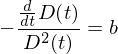

In [3]:
# Set up our function to integrate
a = sym.Symbol('a', real=True, positive=True)
fun_D = sym.Eq((1/D(t)).diff(t), b)
fun_D

This is ugly, but is understood using the identity from the chain rule:  
$ {d \over dt} {1 \over x(t)} = {d \over du} {1 \over u} {du \over dt} $ where $ u = x(t) $  

Evaluating the first derivative on the RHS:  
$ {d \over du} {1 \over u} = {d \over du} {u^{-1}} = {d \over du} {-u^{-2}} = -{1 \over u^2} $  

Simplifying and substituting $ u = x(t) $:  
$ {d \over dt} {1 \over x(t)} = -{1 \over u^2} {du \over dt} = -{{du \over dt} \over u^2} = -{{d \over dt} {x(t)} \over {x(t)}^2}$

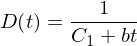

In [4]:
# Solve our function
fun_D_s = sym.dsolve(fun_D, D(t))
sym.simplify(fun_D_s)

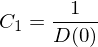

In [5]:
# Define a symbol for the constant of integration
C1 = sym.symbols('C1')

# Evaluate the constant
const = sym.Eq(C1, sym.solve(fun_D_s, C1)[0]).subs([(t, 0)])
const

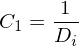

In [6]:
# Define D(0) as Di and substitute
arpsD_const = const.subs([(D(0), Di)])
arpsD_const

##### 2. Using the integrate function
Next, we'll use a simpler method; the Sympy integrate function. This function does *not* produce a constant of integration, but we can easily add one ourselves.

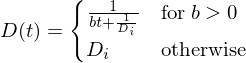

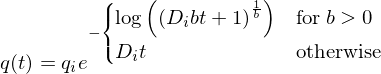

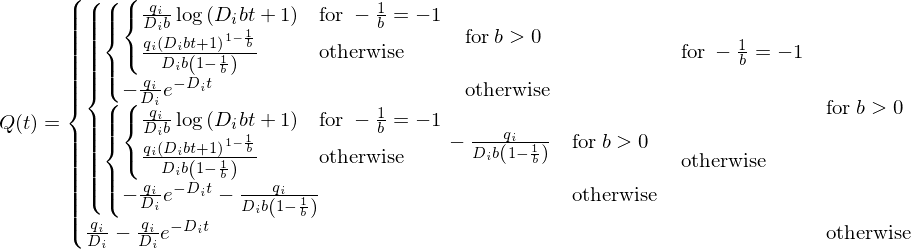

In [7]:
# Set up the symbols we will use and assumptions we can make about their values.
# As engineers, we only care about non-imaginary values!

# Derive the D(t) function. Sympy is not great at identifying singularities,
# so we help it along by defining a piecewise function at b=0.
arpsD = (1 / (sym.integrate(b, (t, 0, t)) + c)).subs([(c, 1/Di)])
arpsD = sym.Piecewise((arpsD, b>0), (arpsD.subs([(b, 0)]), True) )

# Derive the q(t) function. Logcombine simplifies our solution to force
# reduction of exp(ln(x)) to x.
arpsq = sym.integrate(arpsD, (t, 0, t))
arpsq = sym.logcombine(sym.exp(sym.log(qi) -1*(arpsq)), force=True)

# Sympy saves us a lot of effort here! Our piecewise function grows to include
# a special case when b=1.
arpscum = sym.integrate(arpsq, (t, 0, t))

#Represent these as functions for display
D_eq = sym.Eq(D(t), arpsD)
q_eq = sym.Eq(q(t), arpsq)
Q_eq = sym.Eq(Q(t), arpscum)
display(D_eq, q_eq, Q_eq)

If we'd like to save our derivations, we can call <code>print()</code> on our objects. We can then assign the resulting output for use in future notebooks!

## Generate Production Profile
Using our symbolic derivation, we can evaluate it at discrete time points in an array. Again, the symbolic derivation has saved us the hassle of writing the $q(t)$ and $Q(t)$ functions ourselves. Generally, it would be better to import a library where these functions already exist for us than to do the derivation ourselves.

In [8]:
#Generate Data Arrays
lentime = 1200 #months, or 100 years
timearr = np.linspace(0,lentime,lentime+1)

# Define the function to apply to our time array
def set_parms(fun, time):
    parms = [(qi, 1000), (Di, .1), (b, 1.), (t, time)]
    return fun.subs(parms)

# Apply our function to the time array using list comprehension
cumprod = (365.25/12) * np.asarray([set_parms(arpscum, time) for time in timearr])

# Avg production is the first difference in cumulative production assuming time steps are unit steps in monthly time values
avgprod = np.ediff1d(cumprod, to_begin=0) / (365.12/12)

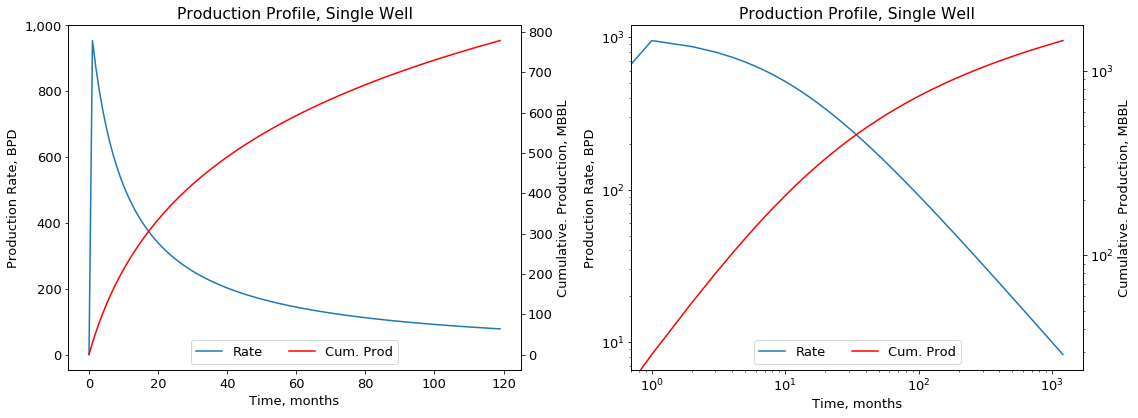

In [9]:
#Plot Production Profile
mpl.rcParams['font.size'] = 13
fig = plt.figure(figsize=(16,6))

shorttime = 120
ax1 = fig.add_subplot(121)
plot1, = ax1.plot(timearr[:shorttime], avgprod[:shorttime], label='Rate')
ax2 = ax1.twinx()
plot2, = ax2.plot(timearr[:shorttime], cumprod[:shorttime]/1000., c='r', label='Cum. Prod')
ax1.set(title='Production Profile, Single Well',
       ylabel='Production Rate, BPD',
       xlabel='Time, months')
ax2.set(ylabel='Cumulative. Production, MBBL')
ax2.legend(handles=[plot1, plot2], loc='lower center', ncol=2)
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()

ax1 = fig.add_subplot(122)
plot1, = ax1.loglog(timearr, avgprod, label='Rate')
ax2 = ax1.twinx()
plot2, = ax2.loglog(timearr, cumprod/1000., c='r', label='Cum. Prod')
ax1.set(title='Production Profile, Single Well',
       ylabel='Production Rate, BPD',
       xlabel='Time, months')
ax2.set(ylabel='Cumulative. Production, MBBL')
ax2.legend(handles=[plot1, plot2], loc='lower center', ncol=2)

plt.tight_layout()
plt.show()

## Construct a rigline
<b>Assume increasing rig count</b>
- $1{st}$ $year$: 1 well every other month
- $2{nd}$ $year$: 1 well every month
- $3{rd}$ - $6{th}$ $years$: 2 wells every month

In [10]:
#Build Rigline
pattern_yr1 = np.asarray([1.,.0])
pattern_yr2 = np.asarray([1.,1.])
pattern_yr3 = np.asarray([2.,2.])
rigline_yr1 = np.tile(pattern_yr1,6)
rigline_yr2 = np.tile(pattern_yr2,6)
rigline_yr3 = np.tile(pattern_yr3,6)
rigline_rem = np.tile(rigline_yr3,3)
rigline = np.concatenate([rigline_yr1,rigline_yr2,rigline_yr3,rigline_rem])

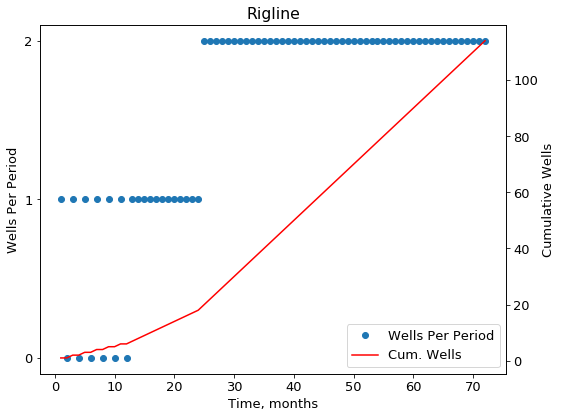

In [11]:
#Plot Rigline
mpl.rcParams['font.size'] = 13
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
wells, = ax1.plot(np.arange(6*12)+1,rigline, ls='none', marker='o', label='Wells Per Period')
ax2 = ax1.twinx()
cumwells, = ax2.plot(np.arange(6*12)+1,np.cumsum(rigline), color='r', label='Cum. Wells')
ax1.set(title='Rigline',
       ylabel='Wells Per Period',
       xlabel='Time, months',
       yticks=([0, 1, 2]))
ax2.set(ylabel='Cumulative Wells')
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.legend(handles=[wells, cumwells], loc='lower right')

plt.tight_layout()
plt.show()

# Magic Happens Here
Here is where we build the growth profile. The convolution integral is:<br/>
$x(t)=\int_{0}^{t}{f(\tau) g^\prime (t - \tau) d\tau}$  

Or in plain terms, $f(t)$ is our production profile (or any other profile!), and $g(t)$ is the # of wells in the period.  

The convolution "mode" tells the function how to handle arrays of different sizes. Given our function $f(t)$ is of size $n$ and our function $g(t)$ is of size $m$, we could:  
1. Pad our well schedule with zeroes so that it is size $m=2n - 1$. Then, we would use mode 'valid' which would generate an array sized to the smallest size of the two arrays passed to the function (in this case, our production profile of size $n$). However, this would require much more computation time as we'd have a pad of size $2n-1-m = 1129$ zeros.
2. Use the mode 'full' which will return all edge values. This will give an array of $n + (m-1)$, which we can then simply truncate. Because our *kernel* (well schedule) is a much smaller size than option 1, this is more computationally efficient.

In [12]:
# Convolve Profiles with Rigline
riglinecumprod = np.convolve(cumprod, rigline, mode='full')[:len(timearr)] #truncate array to be of same length as timearr
riglineavgprod = np.ediff1d(riglinecumprod, to_begin=0) / (365.25/12)

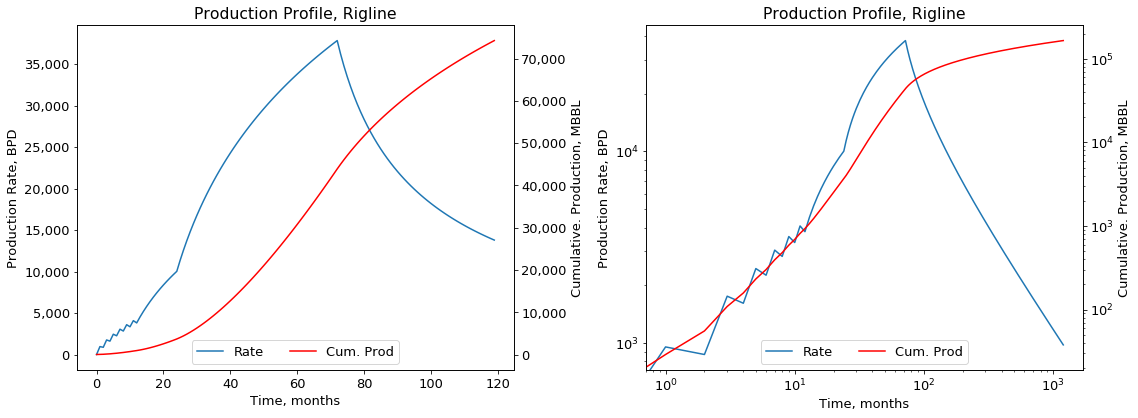

In [13]:
mpl.rcParams['font.size'] = 13
fig = plt.figure(figsize=(16,6))

#Plot small number of months
ax1 = fig.add_subplot(121)
plot1, = ax1.plot(timearr[:shorttime], riglineavgprod[:shorttime], label='Rate')
ax2 = ax1.twinx()
plot2, = ax2.plot(timearr[:shorttime], riglinecumprod[:shorttime]/1000., c='r', label='Cum. Prod')
ax1.set(title='Production Profile, Rigline',
       ylabel='Production Rate, BPD',
       xlabel='Time, months')
ax2.set(ylabel='Cumulative. Production, MBBL')
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.legend(handles=[plot1, plot2], loc='lower center', ncol=2)

#Plot full time array
ax1 = fig.add_subplot(122)
plot1, = ax1.loglog(timearr, riglineavgprod, label='Rate')
ax2 = ax1.twinx()
plot2, = ax2.loglog(timearr, riglinecumprod/1000., c='r', label='Cum. Prod')
ax1.set(title='Production Profile, Rigline',
       ylabel='Production Rate, BPD',
       xlabel='Time, months')
ax2.set(ylabel='Cumulative. Production, MBBL')
ax2.legend(handles=[plot1, plot2], loc='lower center', ncol=2)

plt.tight_layout()
plt.show()

##### And voila!